This document demonstrate how to use the library to define a "density dependent population process" and to compute its mean-field approximation and refined mean-field approximation 

In [1]:
# To load the library
import src.rmf_tool as rmf

import importlib
importlib.reload(rmf)

# To plot the results
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Example : The two-choice model

This example illustrate **two ways** of constructing models:
* How to define transitions with a **for loop**  (using the 'eval' function)
* How to use a parameter in the transitions 

The transitions for this model are: 
* $x \mapsto x + \frac1N e_k$ at rate $\rho (x_{k-1}x_{k-1} - x_k x_k)$
* $x \mapsto x - \frac1N e_k$ at rate $\rho (x_k - x_{k+1})$

with the convention : $x_{-1} = 1$ and $x_{K} = 0$ for some $K$. 

In [2]:
# This code creates an object that represents a "density dependent population process"
ddpp = rmf.DDPP()
K = 20

# The vector 'e(i)' is a vector where the $i$th coordinate is equal to $1$ (the other being equal to $0$)
def e(i):
    l = np.zeros(K)
    l[i] = 1
    return(l)

# We then add the transitions : 
for i in range(K):
    if i>=1:
        ddpp.add_transition(e(i),eval('lambda x: rho*(x[{}]*x[{}] - x[{}]*x[{}] )'.format(i-1,i-1,i,i) ))
    if i<K-1:
        ddpp.add_transition(-e(i),eval('lambda x: (x[{}] - x[{}])'.format(i,i+1) ))
ddpp.add_transition(e(0), lambda x : rho*(1-x[0]*x[0]))
ddpp.add_transition(-e(K-1), lambda x : x[K-1])



## Simulation and comparison with ODE
We can easily simulate one sample trajectory

### Simulation for various values of $N$

CPU times: user 1.36 s, sys: 50.3 ms, total: 1.41 s
Wall time: 2.46 s
CPU times: user 4.57 s, sys: 177 ms, total: 4.75 s
Wall time: 6.76 s


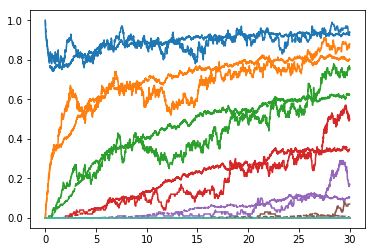

In [4]:
rho = 0.95
ddpp.set_initial_state(e(0)) # We first need to define an initial stater
%time c = ddpp.theoretical_C()

T,X = ddpp.simulate(100,time=30) # We first plot a trajectory for $N=100$
plt.plot(T,X)
%time T,X = ddpp.simulate(1000,time=30) # Then for $N=1000$
plt.plot(T,X,'--')

### Comparison with the ODE approximation 
We can easily compare simulations with the ODE approximation

In [3]:
plt.figure()
ddpp.plot_ODE_vs_simulation(N=50)
plt.figure()
ddpp.plot_ODE_vs_simulation(N=1000)

InitialConditionNotDefined: 

## Refined mean-field approximation
(reference to be added)

This class also contains some functions to compute the fixed point of the mean-field approximation, to compute the "refined mean-field approximation" and to compare it with simulations. 

If $x$ is the fixed point of the ODE, and $C$ the constant calculated by the function "theoretical_C()", then we have 

$$E[X^N] = x + \frac1N C + o(\frac1N) $$

To compute these constants : 

In [8]:
x = ddpp.fixed_point()
c = ddpp.theoretical_C()
print(x,c)

[  9.50000000e-001   8.57375000e-001   6.98337296e-001   4.63291230e-001
   2.03906826e-001   3.94990939e-002   1.48216950e-003   2.08698510e-006
   4.13773147e-012   1.62647806e-023   2.51316110e-046  -5.31064890e-070
  -4.48629830e-084   1.31947183e-098   2.45469343e-111   3.06455879e-125
  -4.33676600e-140  -4.09352804e-153  -2.44154144e-167   6.35943787e-181] [  5.59448321e-017   7.43796815e-002   4.57609741e-001   1.62142167e+000
   3.34929643e+000   2.88723561e+000   4.84199821e-001   4.21066459e-003
   2.01887602e-006   3.93088444e-012   1.54515416e-023   2.38750221e-046
  -2.52255823e-070  -2.13099169e-084   6.26749118e-099   1.16597938e-111
   1.45566542e-125  -2.05996385e-140  -1.94442582e-153  -1.15973218e-167]


### Comparison of theoretical C and simulation 

We observe that, for this model, the mean-field approximation is already very close to the simulation. 

**Warning** : for $time=100000/N$, the simulation takes about $10$ sec per value of $N$ but is not that accurate

In [21]:
print(sum(x),'(mean-field)')

myN = [10,20,30,50,100]
Xs = {}
Vs = {}
Xrmf = {}
for N in myN:
    %time Xs[N],Vs[N] = ddpp.steady_state_simulation(N=N,time=100000/N) 
    Xrmf[N] = x+c/N
    print(N,'done')

3.21389370239 (mean-field)
CPU times: user 17 s, sys: 618 ms, total: 17.6 s
Wall time: 27.8 s
10 done
CPU times: user 16.8 s, sys: 603 ms, total: 17.4 s
Wall time: 27.9 s
20 done
CPU times: user 16.4 s, sys: 594 ms, total: 17 s
Wall time: 24.4 s
30 done
CPU times: user 17.3 s, sys: 618 ms, total: 17.9 s
Wall time: 27.8 s
50 done
CPU times: user 16.1 s, sys: 575 ms, total: 16.7 s
Wall time: 24.2 s
100 done


#### Refined mean-field for the average queue length 
The average queue length is accurately predicted by the refined mean-field 

In [22]:
# Average queue length : 
for N in myN : 
    print(sum(Xs[N]),'+/-',sum(Vs[N]),'(Simulation, N={})'.format(N))
    print(sum(Xrmf[N]),'(refined mean-field, N={})'.format(N))

4.82037406408 +/- 0.561179534435 (Simulation, N=10)
4.10172926564 (refined mean-field, N=10)
3.66822329777 +/- 0.26592568044 (Simulation, N=20)
3.65781148402 (refined mean-field, N=20)
3.51613720174 +/- 0.165640227971 (Simulation, N=30)
3.50983889014 (refined mean-field, N=30)
3.34393658602 +/- 0.143735594196 (Simulation, N=50)
3.39146081504 (refined mean-field, N=50)
3.415156923 +/- 0.100801469825 (Simulation, N=100)
3.30267725872 (refined mean-field, N=100)


#### Queue length distribution 

Interestingly, the distribution is not really predicted well for $N=10$ (the refined mean-field over-correct the values around 5).  it seems better for $N\ge30$. 


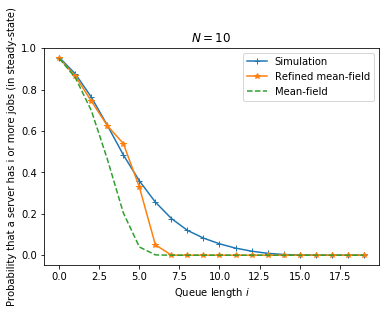

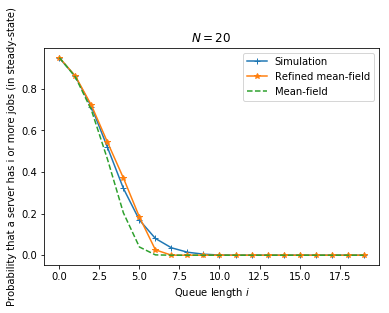

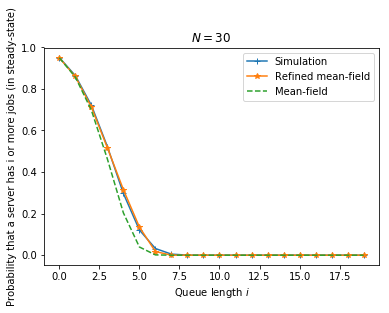

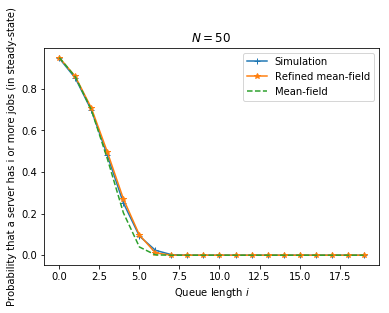

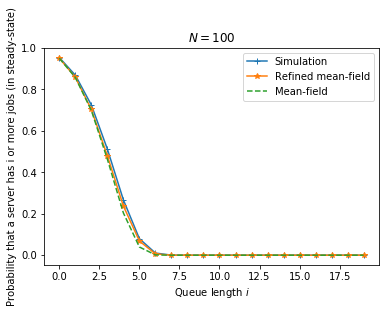

In [23]:
for N in myN:
    plt.figure()
    #plt.errorbar(range(K-1),-np.diff(Xs[N]),np.diff(-Vs[N]))
    #plt.plot(-np.diff(Xs[N]),'+-')
    #plt.plot(-np.diff(Xrmf[N]),'*-')
    #plt.plot(-np.diff(x),'--')
    plt.plot((Xs[N]),'+-')
    plt.plot((Xrmf[N]),'*-')
    plt.plot((x),'--')
    plt.legend(('Simulation','Refined mean-field','Mean-field'))
    plt.xlabel('Queue length $i$')
    plt.ylabel('Probability that a server has i or more jobs (in steady-state)')
    plt.title('$N={}$'.format(N))